# Celosia - Zero-day attack detection demo

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

Using TensorFlow backend.


In [2]:
# Make sure that the dataset exists
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
# Importing benign gafgyt combo dataset for a given device id (1-9)
def import_dataset_benign_gagfyt_combo(device_id):
    normal = pd.read_csv('../input/nbaiot-dataset/{}.benign.csv'.format(device_id))
    n_X = normal.iloc[:,]
    n_X_scaled = MinMaxScaler().fit_transform(n_X.values)
    n_y = np.ones(n_X.shape[0]) # 1 represents normal

    anomalous = pd.read_csv('../input/nbaiot-dataset/{}.gafgyt.combo.csv'.format(device_id))
    a_X = anomalous.iloc[:,]
    a_X_scaled = MinMaxScaler().fit_transform(a_X.values)
    a_y = np.zeros(a_X.shape[0]) # 0 represents anomalous

    #normal.info()
    #normal.describe()
    #normal.head()

    #anomalous.info()
    #anomalous.describe()
    #anomalous.head()

    return (n_X_scaled, n_y, a_X_scaled, a_y)

In [4]:
# AutoEncoder

def generate_and_train_autoencoder(X):
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")

    autoencoder.fit(X[0:1000], X[0:1000], 
                    batch_size = 256, epochs = 10, 
                    shuffle = True, validation_split = 0.20);

    return autoencoder

In [5]:
# hidden representation
def get_hidden_representation_normal_anomalous(autoencoder, n_X, a_X):
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    normal_hid_rep = hidden_representation.predict(n_X[:3000])
    anomalous_hid_rep = hidden_representation.predict(a_X[:3000])

    return (normal_hid_rep, anomalous_hid_rep)

In [6]:
def tsne_plot(x, y, title="Scatter Plot", name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Anomalous')

    plt.title(title)
    plt.legend(loc='best');
    plt.savefig('{}-{}'.format(title,name));
    plt.show();

In [7]:
# Combine normal and anomalous data
def combine_normal_anomalous(normal, anomalous):
    X = np.append(normal, anomalous, axis = 0)
    y_n = np.ones(normal.shape[0])
    y_a = np.zeros(anomalous.shape[0])
    y = np.append(y_n, y_a)

    return (X, y)

In [8]:
# Evaluate model's performace
def evaluate_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
    clf = LogisticRegression(solver="lbfgs").fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    return (test_y, pred_y)

In [9]:
# Show model's report
def show_model_report(title, X, y, hid_X, hid_y, test_y, pred_y):
    #tsne_plot(X, y, '{}-original'.format(title), "original.png")
    tsne_plot(hid_X, hid_y, title, "hidden_representation.png")

    print(title)
    print ("")
    print ("Classification Report: ")
    print (classification_report(test_y, pred_y))

    print ("")
    print ("Accuracy Score: ", accuracy_score(test_y, pred_y))

In [10]:
# Detect zero-day attack
def detect_zero_day_attack(device_name, device_id):
    (n_X_scaled, n_y, a_X_scaled, a_y) = import_dataset_benign_gagfyt_combo(device_id)
    autoencoder = generate_and_train_autoencoder(n_X_scaled)
    (normal_hid_rep, anomalous_hid_rep) = get_hidden_representation_normal_anomalous(autoencoder, n_X_scaled, a_X_scaled)
    (X, y) = combine_normal_anomalous(n_X_scaled, a_X_scaled)
    (hid_X, hid_y) = combine_normal_anomalous(normal_hid_rep, anomalous_hid_rep)
    (test_y, pred_y) = evaluate_model(hid_X, hid_y)
    show_model_report(device_name, X, y, hid_X, hid_y, test_y, pred_y)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 576us/step - loss: 0.4323 - val_loss: 0.2865
Epoch 2/10
800/800 [==============================] - 0s 24us/step - loss: 0.3279 - val_loss: 0.2142
Epoch 3/10
800/800 [==============================] - 0s 24us/step - loss: 0.2513 - val_loss: 0.1625
Epoch 4/10
800/800 [==============================] - 0s 23us/step - loss: 0.1982 - val_loss: 0.1291
Epoch 5/10
800/800 [==============================] - 0s 22us/step - loss: 0.1641 - val_loss: 0.1074
Epoch 6/10
800/800 [==============================] - 0s 23us/step - loss: 0.1423 - val_loss: 0.0933
Epoch 7/10
800/800 [==============================] - 0s 22us/step - loss: 0.1291 - val_loss: 0.0842
Epoch 8/10
800/800 [==============================] - 0s 24us/step - loss: 0.1190 - val_loss: 0.0764
Epoch 9/10
800/800 [==============================] - 0s 23us/step - loss: 0.1116 - val_loss: 0.0717
Epoch 10/10
800/800 [=======================

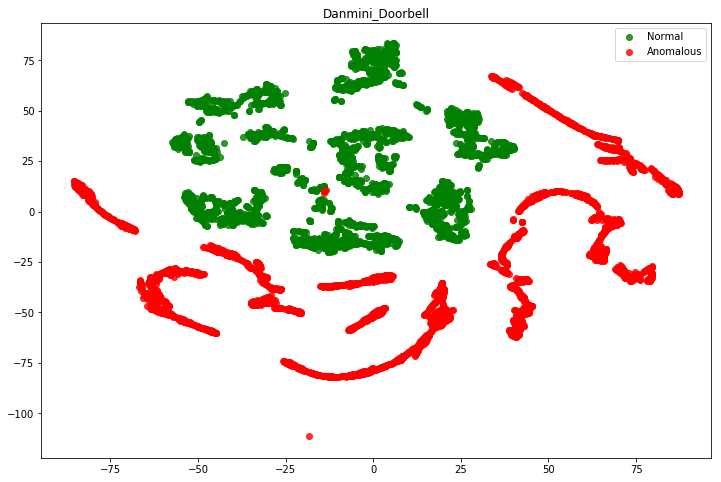

Danmini_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       763
         1.0       1.00      1.00      1.00       737

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 276us/step - loss: 0.6038 - val_loss: 0.3856
Epoch 2/10
800/800 [==============================] - 0s 25us/step - loss: 0.4537 - val_loss: 0.2916
Epoch 3/10
800/800 [==============================] - 0s 24us/step - loss: 0.3562 - val_loss: 0.2303
Epoch 4/10
800/800 [==============================] - 0s 24us/step - loss: 0.2924 - val_loss: 0.1921
Epoch 5/10
800/800 [==============================] - 0s 24us/step - loss: 0.2513 - val_loss: 0.1650
Epoch 6/10
800/800 [======================

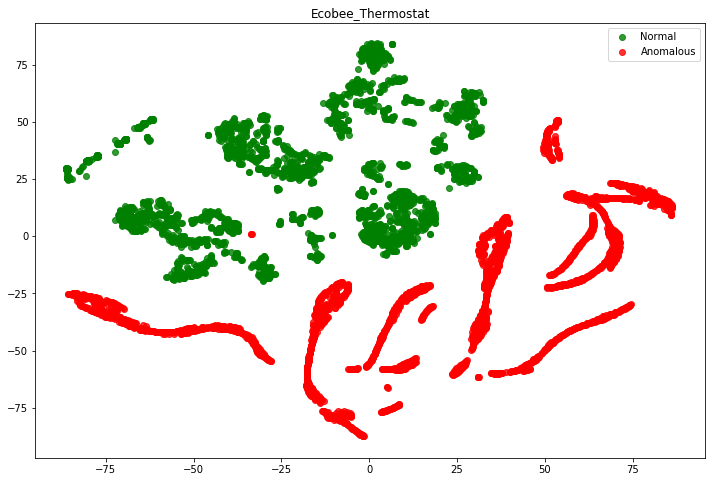

Ecobee_Thermostat

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       777
         1.0       1.00      1.00      1.00       723

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 282us/step - loss: 0.5998 - val_loss: 0.3995
Epoch 2/10
800/800 [==============================] - 0s 25us/step - loss: 0.4549 - val_loss: 0.2976
Epoch 3/10
800/800 [==============================] - 0s 23us/step - loss: 0.3466 - val_loss: 0.2226
Epoch 4/10
800/800 [==============================] - 0s 24us/step - loss: 0.2661 - val_loss: 0.1690
Epoch 5/10
800/800 [==============================] - 0s 23us/step - loss: 0.2093 - val_loss: 0.1356
Epoch 6/10
800/800 [==============================] - 0s

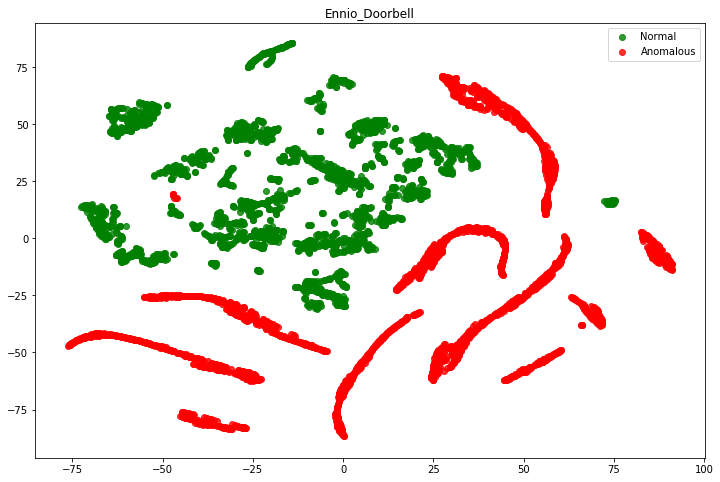

Ennio_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       739
         1.0       1.00      1.00      1.00       761

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9986666666666667
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 352us/step - loss: 1.1465 - val_loss: 0.7044
Epoch 2/10
800/800 [==============================] - 0s 28us/step - loss: 0.7589 - val_loss: 0.6508
Epoch 3/10
800/800 [==============================] - 0s 28us/step - loss: 0.5401 - val_loss: 0.6265
Epoch 4/10
800/800 [==============================] - 0s 26us/step - loss: 0.4338 - val_loss: 0.6227
Epoch 5/10
800/800 [==============================] - 0s 28us/step - loss: 0.3999 - val_loss: 0.6162
Epoch 6/10
800/800 [========================

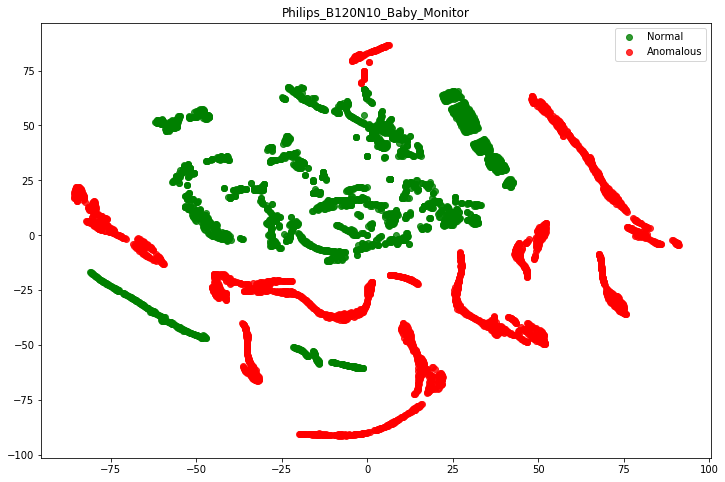

Philips_B120N10_Baby_Monitor

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       757
         1.0       1.00      1.00      1.00       743

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 286us/step - loss: 0.4833 - val_loss: 0.2327
Epoch 2/10
800/800 [==============================] - 0s 24us/step - loss: 0.3884 - val_loss: 0.1810
Epoch 3/10
800/800 [==============================] - 0s 25us/step - loss: 0.3177 - val_loss: 0.1453
Epoch 4/10
800/800 [==============================] - 0s 23us/step - loss: 0.2683 - val_loss: 0.1197
Epoch 5/10
800/800 [==============================] - 0s 25us/step - loss: 0.2352 - val_loss: 0.0992
Epoch 6/10
800/800 [=========================

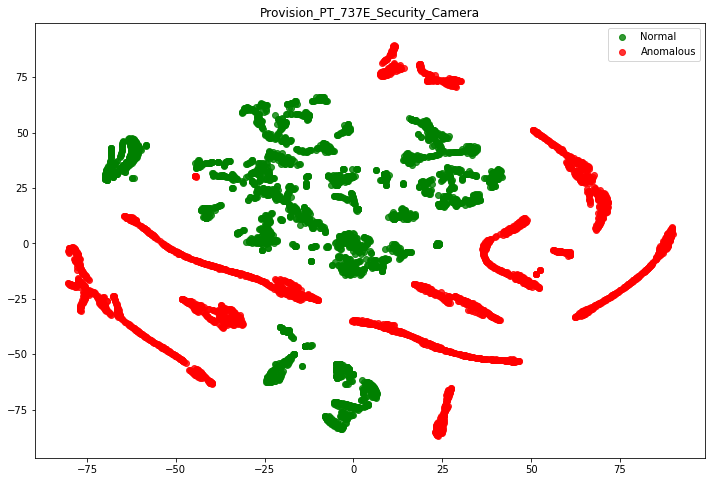

Provision_PT_737E_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       715
         1.0       1.00      1.00      1.00       785

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 297us/step - loss: 0.5564 - val_loss: 0.4019
Epoch 2/10
800/800 [==============================] - 0s 28us/step - loss: 0.4532 - val_loss: 0.3315
Epoch 3/10
800/800 [==============================] - 0s 29us/step - loss: 0.3704 - val_loss: 0.2760
Epoch 4/10
800/800 [==============================] - 0s 29us/step - loss: 0.3087 - val_loss: 0.2347
Epoch 5/10
800/800 [==============================] - 0s 28us/step - loss: 0.2667 - val_loss: 0.2079
Epoch 6/10
800/800 [====================

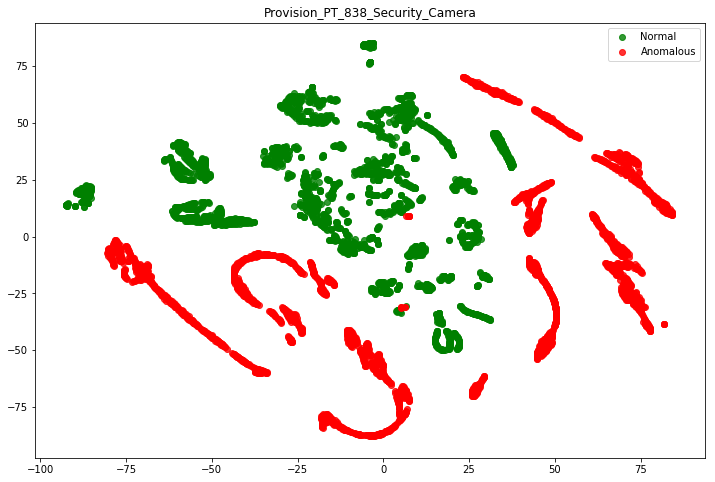

Provision_PT_838_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       750
         1.0       1.00      1.00      1.00       750

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 303us/step - loss: 0.5360 - val_loss: 0.3438
Epoch 2/10
800/800 [==============================] - 0s 27us/step - loss: 0.4029 - val_loss: 0.2561
Epoch 3/10
800/800 [==============================] - 0s 25us/step - loss: 0.3133 - val_loss: 0.1978
Epoch 4/10
800/800 [==============================] - 0s 27us/step - loss: 0.2546 - val_loss: 0.1609
Epoch 5/10
800/800 [==============================] - 0s 27us/step - loss: 0.2162 - val_loss: 0.1369
Epoch 6/10
800/800 [=====================

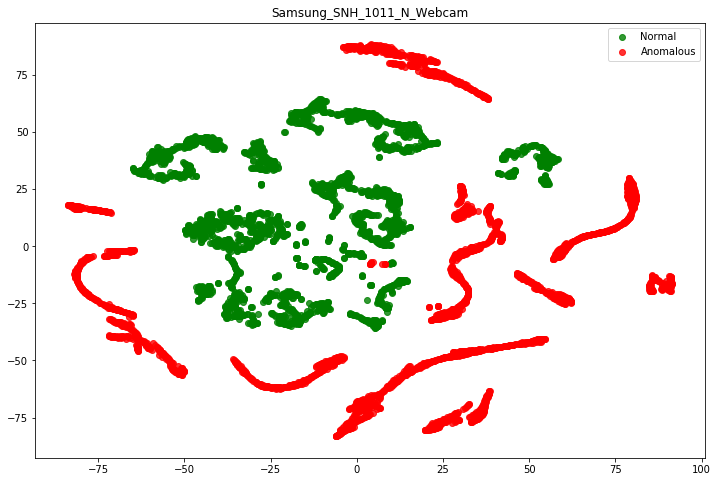

Samsung_SNH_1011_N_Webcam

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       773
         1.0       1.00      1.00      1.00       727

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 284us/step - loss: 0.6124 - val_loss: 0.4639
Epoch 2/10
800/800 [==============================] - 0s 24us/step - loss: 0.4846 - val_loss: 0.3850
Epoch 3/10
800/800 [==============================] - 0s 24us/step - loss: 0.3899 - val_loss: 0.3267
Epoch 4/10
800/800 [==============================] - 0s 25us/step - loss: 0.3270 - val_loss: 0.2885
Epoch 5/10
800/800 [==============================] - 0s 25us/step - loss: 0.2857 - val_loss: 0.2601
Epoch 6/10
800/800 [============================

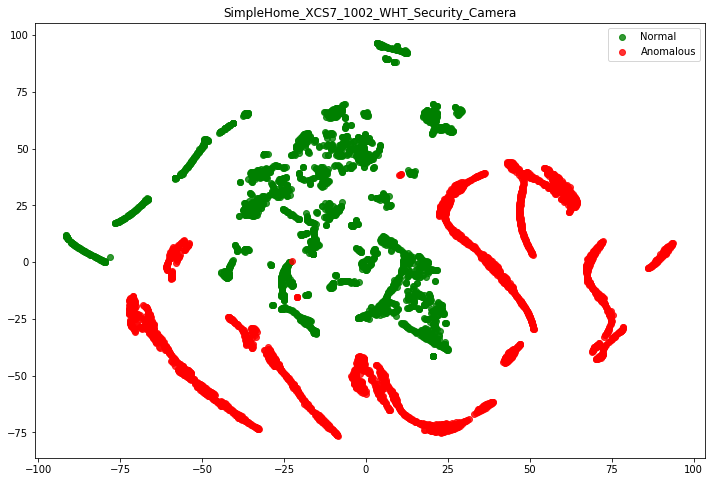

SimpleHome_XCS7_1002_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       730
         1.0       1.00      1.00      1.00       770

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 281us/step - loss: 0.6230 - val_loss: 0.3777
Epoch 2/10
800/800 [==============================] - 0s 25us/step - loss: 0.4897 - val_loss: 0.2810
Epoch 3/10
800/800 [==============================] - 0s 25us/step - loss: 0.3873 - val_loss: 0.2140
Epoch 4/10
800/800 [==============================] - 0s 22us/step - loss: 0.3138 - val_loss: 0.1717
Epoch 5/10
800/800 [==============================] - 0s 23us/step - loss: 0.2668 - val_loss: 0.1386
Epoch 6/10
800/800

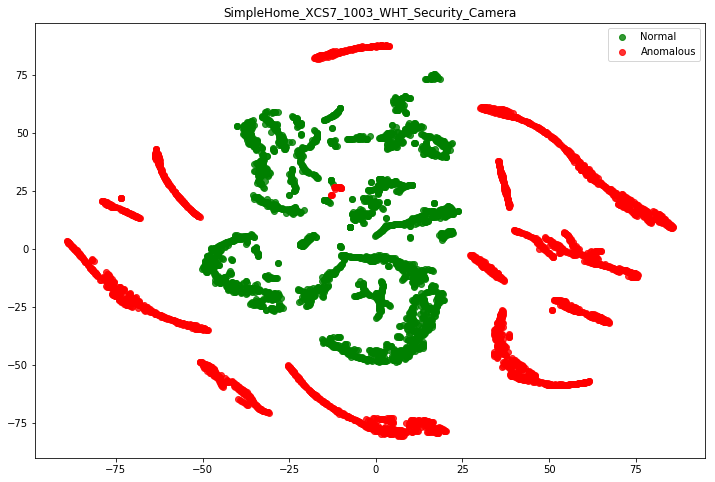

SimpleHome_XCS7_1003_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       768
         1.0       1.00      1.00      1.00       732

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


In [11]:
devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']
#devices = ['Danmini_Doorbell', 'Ecobee_Thermostat']
for device_id, device_name in enumerate(devices, 1):
    detect_zero_day_attack(device_name, device_id)
